<a href="https://colab.research.google.com/github/vadaliah/CS5260/blob/master/VWAP%20ML%20Model%20Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forex VWAP(Volume Weighted Average Price) ML Solution
This notebook demonstrates Machine Learning solution to predict VWAP direction for given currency pair based on historical volume dataset

Problem Formulation
In this example, we will use Historical Currencypair price volume dataset provided from FOREX Tester APP, available here: https://forextester.com/data/datasources.
The dataset contains Hourly pricing data of 6 currency pair (EURUSD, GBPUSD, AUDUSD, NZSUSD, USDJPY and USDCHF) for April 2018

Data Dictionary
  1  
 1   Ticker        CurrencyPair of the Trade
 2   BusinessDate  BusinessDate  
 3   TimeBucket    Hourly Time Bucket 
 4   TradeTime     Trade Time in HH:MM  
 5   TradePrice    Trade Price
 6   Open          Opening Price for the TimeBucket Interval
 8   High          High Price for the TimeBucket Interval
 9   Low           Low Price for the Time Bucket interval
 10   Close        Closing Price for the TimeBucket Interval
 11  AvgPrice      AvgPrice for the TimeBucket Interval
 12  PV            PriceVolume for the interval
 13  VWAP         Volume Weighted Avg Price for the interval
 14  Trend        "Goal" Trend of the price "UpTrend", DownTrend" 

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
fx_volume_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/currencypair_volume_datset.csv'
fx_volume_df = pd.read_csv(fx_volume_file)
fx_volume_df.sample(5)
print(fx_volume_df.shape)
print(fx_volume_df.size)
fx_volume_df.head().values

fx_trade_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/trade_dataset.csv'
fx_trade_df = pd.read_csv(fx_trade_file)
fx_trade_df = fx_trade_df.replace(r'^\s*$', np.nan, regex=True)  # Trim trailing spaces
fx_trade_df.dropna() # Drop nan records
print(fx_trade_df.shape)
print(fx_trade_df.size)
fx_trade_df.head().values


(3013, 8)
24104
(13152, 13)
170976


array([['USDJPY', 20180401, '21:00', 2101, 106.167, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2102, 106.189, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2105, 106.221, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2106, 106.219, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2107, 106.222, 106.167, 106.268,
        106.167, 106.26, 106.2155, 106.2155, 106.2155, 'UpTrend']],
      dtype=object)

In [ ]:
	fx_volume_df.info()
	fx_volume_df.columns
	fx_volume_df['Ticker'].value_counts()
	fx_volume_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        3013 non-null   object 
 1   BusinessDate  3013 non-null   int64  
 2   TimeBucket    3013 non-null   object 
 3   Open          3013 non-null   float64
 4   High          3013 non-null   float64
 5   Low           3013 non-null   float64
 6   Close         3013 non-null   float64
 7   Volume        3013 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 188.4+ KB


Ticker  BusinessDate  TimeBucket
GBPUSD  20180406      20:00         2
NZDUSD  20180410      20:00         2
USDCHF  20180406      10:00         2
NZDUSD  20180410      10:00         2
        20180427      10:00         2
                                   ..
EURUSD  20180430      18:00         1
                      19:00         1
                      1:00          1
                      20:00         1
USDJPY  20180430      9:00          1
Length: 2831, dtype: int64

In [ ]:
	fx_trade_df.info()
	fx_trade_df.columns
	fx_trade_df['Ticker'].value_counts()
	fx_trade_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        13152 non-null  object 
 1   BusinessDate  13152 non-null  int64  
 2   TimeBucket    13152 non-null  object 
 3   TradeTime     13152 non-null  int64  
 4   TradePrice    13152 non-null  float64
 5   Open          13152 non-null  float64
 6   High          13152 non-null  float64
 7   Low           13152 non-null  float64
 8   Close         13152 non-null  float64
 9   AvgPrice      13152 non-null  float64
 10  PV            13152 non-null  float64
 11  VWAP          13152 non-null  float64
 12  Trend         13152 non-null  object 
dtypes: float64(8), int64(2), object(3)
memory usage: 1.3+ MB


Ticker  BusinessDate  TimeBucket
USDJPY  20180430      10:00         93
EURUSD  20180420      10:00         93
AUDUSD  20180430      10:00         93
NZDUSD  20180420      11:00         93
                      10:00         93
                                    ..
        20180430      5:00          13
EURUSD  20180420      5:00          13
NZDUSD  20180430      4:00          13
EURUSD  20180420      4:00          13
GBPUSD  20180420      4:00          13
Length: 220, dtype: int64

	Exploratory Data Anaysis
	1. Ensure data is complete, verify presence of data for all 6 currency pair is present in the volume dataset
	2. Verify count of data by currencypair, businessdate combination. Any currencypair with insufficient data will skew VWAP results and result in inaccurate model outcome
  3. Verify Trading dataset is complete, contains currency pair and business dates in scope
	

UpTrend      7383
DownTrend    5769
Name: Trend, dtype: int64

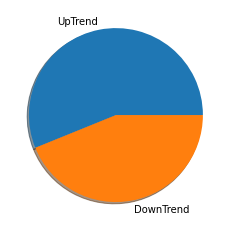

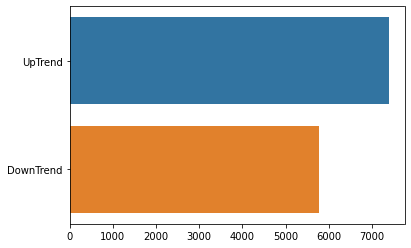

In [ ]:
trend_counts =fx_trade_df['Trend'].value_counts()
display(trend_counts)
plt.pie(trend_counts,labels=trend_counts.index,shadow=True )
plt.show()
sns.barplot(y=trend_counts.index, x=trend_counts.values,orient='h')

EURUSD    2878
GBPUSD    2876
AUDUSD    2874
NZDUSD    2853
USDJPY    2846
Name: Ticker, dtype: int64

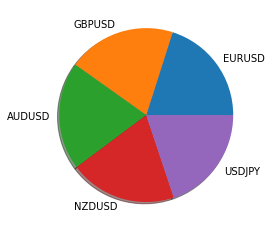

Ticker  BusinessDate
EURUSD  20180430        1440
GBPUSD  20180430        1439
AUDUSD  20180430        1438
NZDUSD  20180430        1436
USDJPY  20180430        1432
AUDUSD  20180420        1260
EURUSD  20180420        1260
GBPUSD  20180420        1260
NZDUSD  20180420        1260
USDJPY  20180420        1258
EURUSD  20180401         178
GBPUSD  20180401         177
AUDUSD  20180401         176
NZDUSD  20180401         157
USDJPY  20180401         156
dtype: int64

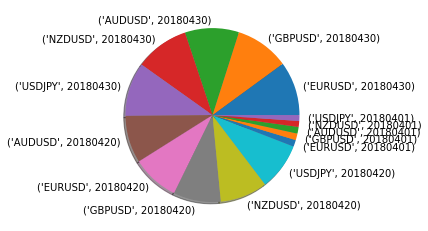

In [ ]:
# Plot of Trade Data to visualize currency pair(Ticker) and data count for CurrencyPair, Business Date
ticker_counts =fx_trade_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_trade_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()



EURUSD    507
USDJPY    502
USDCHF    502
NZDUSD    502
AUDUSD    500
GBPUSD    500
Name: Ticker, dtype: int64

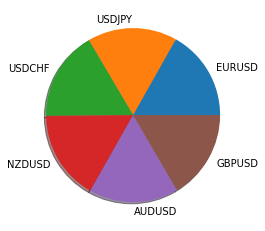

Ticker  BusinessDate
USDJPY  20180430        24
GBPUSD  20180417        24
NZDUSD  20180409        24
        20180405        24
        20180404        24
                        ..
USDCHF  20180401         3
        20180408         3
        20180415         3
        20180422         3
NZDUSD  20180401         3
Length: 156, dtype: int64

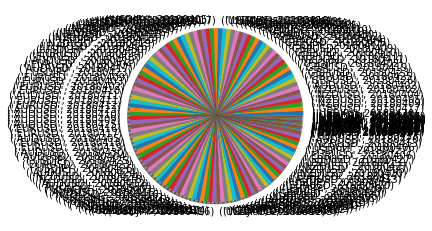

In [ ]:
# Plot of Volume Data to visualize currency pair(Ticker) 
# Plot of data count for CurrencyPair, Business Date
ticker_counts =fx_volume_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_volume_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()
#sns.barplot(y=ticker_counts.index, x=ticker_counts.values,orient='h')

In [ ]:
#Feature Engineering
# Compute Avg Price = Avg(open,close,high,low)
#fx_volume_df.set_index(['Open', 'Close','High','Low'], append=True)
fx_volume_df['AvgPrice'] = fx_volume_df[['Open', 'Close','High','Low']].mean(axis=1)


# Compute Consolidate Key of Ticker, BusinessDate, TimeBucke
fx_volume_df['Key'] = fx_volume_df['Ticker']+"-"+fx_volume_df['BusinessDate'].astype(str)+"-"+fx_volume_df['TimeBucket'].astype(str)
fx_volume_df.head()


,Ticker,BusinessDate,TimeBucket,Open,High,Low,Close,Volume,AvgPrice,Key
0,AUDUSD,20180401,21:00,0.76855,0.76928,0.76844,0.76888,356150000,0.768787,AUDUSD-20180401-21:00
1,AUDUSD,20180401,22:00,0.76884,0.76884,0.76834,0.76859,830980000,0.768652,AUDUSD-20180401-22:00
2,AUDUSD,20180401,23:00,0.76856,0.76860,0.76807,0.76828,1865340000,0.768377,AUDUSD-20180401-23:00
3,AUDUSD,20180402,0:00,0.76828,0.76946,0.76817,0.76929,2957570000,0.768800,AUDUSD-20180402-0:00
4,AUDUSD,20180402,10:00,0.76927,0.76947,0.76821,0.76843,2352190000,0.768845,AUDUSD-20180402-10:00


In [45]:
# Train Test Split
from sklearn.model_selection import train_test_split
class_column = ['Trend']
random_seed = 500
features = fx_trade_df.drop(columns=class_column)
target = fx_trade_df[class_column]
fx_trade_df=fx_trade_df.dropna()
fx_trade_df[class_column]=fx_trade_df[class_column].fillna("EMPTY")
X_train, X_test, y_train,y_test = train_test_split(features,target,test_size=.25,random_state = random_seed,stratify=fx_trade_df[class_column])

In [46]:
print("on X Train")
print ("X train dimensions", X_train.shape)
display(X_train.head())

print ("on x test")
print ("x test dimensions", X_test.shape)
display(X_test.head())


on X Train
X train dimensions (9864, 12)


,Ticker,BusinessDate,TimeBucket,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP
866,USDJPY,20180420,14:00,1414,107.71200,107.79000,107.85500,107.69100,107.69800,107.758500,107.758500,107.758500
12890,AUDUSD,20180430,19:00,1937,0.75255,0.75296,0.75306,0.75249,0.75269,0.752800,0.752800,0.752800
8463,GBPUSD,20180420,17:00,656,1.40659,1.40371,1.40381,1.40211,1.40329,1.403230,1.403230,1.403230
10946,AUDUSD,20180420,19:00,434,0.77161,0.76673,0.76696,0.76630,0.76668,0.766667,0.766667,0.766667
6792,NZDUSD,20180430,17:00,416,0.70757,0.70511,0.70516,0.70370,0.70411,0.704520,0.704520,0.704520


on x test
x test dimensions (3288, 12)


,Ticker,BusinessDate,TimeBucket,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP
2391,USDJPY,20180430,20:00,2052,109.31900,109.31600,109.33600,109.28300,109.33000,109.316250,109.316250,109.316250
2581,EURUSD,20180401,21:00,2104,1.23172,1.23199,1.23230,1.23165,1.23204,1.231995,1.231995,1.231995
6881,NZDUSD,20180430,7:00,556,0.70798,0.70735,0.70739,0.70621,0.70654,0.706873,0.706873,0.706873
3062,EURUSD,20180420,7:00,553,1.23405,1.23422,1.23529,1.23244,1.23249,1.233610,1.233610,1.233610
3293,EURUSD,20180420,10:00,1034,1.23025,1.23013,1.23029,1.22930,1.23024,1.229990,1.229990,1.229990


In [47]:
# y_test.dropna() # Drop nan records
# y_test.fillna("EMPTY")
print("on Y Train")
print ("Y train dimensions", y_train.shape)
display(y_train.head())

print ("on Y test")
print ("Y test dimensions", y_test.shape)
display(y_test.head())


on Y Train
Y train dimensions (9864, 1)


,Trend
866,DownTrend
12890,DownTrend
8463,UpTrend
10946,UpTrend
6792,UpTrend


on Y test
Y test dimensions (3288, 1)


,Trend
2391,UpTrend
2581,DownTrend
6881,UpTrend
3062,UpTrend
3293,UpTrend


In [48]:
# machine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [74]:
# Encode the target as well since it's categorical - we can also transform the target column using pandas
# OneHotEncoder() for categorical feature 
le = LabelEncoder()

ticker_le = le.fit_transform(X_train['Ticker'])
ticker_le_df = pd.DataFrame(ticker_le, columns=["TickerEncoder"])
X_train_transformed=pd.concat([X_train, ticker_le_df], axis=1)
X_train_transformed=X_train_transformed.dropna()
X_train_transformed=X_train_transformed.drop(columns=["Ticker"])

timeBucket_le = le.fit_transform(X_train['TimeBucket'])
timeBucket_le_df = pd.DataFrame(ticker_le, columns=["TimeBucketEncoder"])
X_train_transformed=pd.concat([X_train_transformed, timeBucket_le_df], axis=1)
X_train_transformed=X_train_transformed.dropna()
X_train_transformed=X_train_transformed.drop(columns=["TimeBucket"])
X_train_transformed


,BusinessDate,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP,TickerEncoder,TimeBucketEncoder
0,20180401.0,2101.0,106.16700,106.16700,106.2680,106.16700,106.2600,106.2155,106.2155,106.2155,4.0,4
1,20180401.0,2102.0,106.18900,106.16700,106.2680,106.16700,106.2600,106.2155,106.2155,106.2155,0.0,0
2,20180401.0,2105.0,106.22100,106.16700,106.2680,106.16700,106.2600,106.2155,106.2155,106.2155,2.0,2
4,20180401.0,2107.0,106.22200,106.16700,106.2680,106.16700,106.2600,106.2155,106.2155,106.2155,3.0,3
6,20180401.0,2109.0,106.22800,106.16700,106.2680,106.16700,106.2600,106.2155,106.2155,106.2155,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9854,20180430.0,1125.0,1.37208,1.37272,1.3733,1.37188,1.3729,1.3727,1.3727,1.3727,4.0,4
9858,20180430.0,1129.0,1.37307,1.37272,1.3733,1.37188,1.3729,1.3727,1.3727,1.3727,0.0,0
9859,20180430.0,1130.0,1.37310,1.37272,1.3733,1.37188,1.3729,1.3727,1.3727,1.3727,0.0,0
9861,20180430.0,1132.0,1.37267,1.37272,1.3733,1.37188,1.3729,1.3727,1.3727,1.3727,4.0,4


In [75]:
# Encode the target as well since it's categorical - we can also transform the target column using pandas
# OneHotEncoder() for categorical feature 
le = LabelEncoder()

ticker_le = le.fit_transform(X_test['Ticker'])
ticker_le_df = pd.DataFrame(ticker_le, columns=["TickerEncoder"])
X_test_transformed=pd.concat([X_test, ticker_le_df], axis=1)
X_test_transformed=X_test_transformed.dropna()
X_test_transformed=X_test_transformed.drop(columns=["Ticker"])

timeBucket_le = le.fit_transform(X_train['TimeBucket'])
timeBucket_le_df = pd.DataFrame(ticker_le, columns=["TimeBucketEncoder"])
X_test_transformed=pd.concat([X_test_transformed, timeBucket_le_df], axis=1)
X_test_transformed=X_test_transformed.dropna()
X_test_transformed=X_test_transformed.drop(columns=["TimeBucket"])
X_test_transformed

,BusinessDate,TradeTime,TradePrice,Open,High,Low,Close,AvgPrice,PV,VWAP,TickerEncoder,TimeBucketEncoder
3,20180401.0,2106.0,106.21900,106.16700,106.26800,106.16700,106.26000,106.215500,106.215500,106.215500,1.0,1
5,20180401.0,2108.0,106.21500,106.16700,106.26800,106.16700,106.26000,106.215500,106.215500,106.215500,1.0,1
7,20180401.0,2110.0,106.23700,106.16700,106.26800,106.16700,106.26000,106.215500,106.215500,106.215500,1.0,1
8,20180401.0,2111.0,106.23600,106.16700,106.26800,106.16700,106.26000,106.215500,106.215500,106.215500,4.0,4
12,20180401.0,2115.0,106.22300,106.16700,106.26800,106.16700,106.26000,106.215500,106.215500,106.215500,4.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,20180420.0,925.0,1.23069,1.22812,1.22929,1.22799,1.22846,1.228465,1.228465,1.228465,1.0,1
3257,20180420.0,928.0,1.23030,1.22812,1.22929,1.22799,1.22846,1.228465,1.228465,1.228465,2.0,2
3262,20180420.0,1003.0,1.22949,1.23013,1.23029,1.22930,1.23024,1.229990,1.229990,1.229990,2.0,2
3266,20180420.0,1007.0,1.22979,1.23013,1.23029,1.22930,1.23024,1.229990,1.229990,1.229990,3.0,3


In [81]:
# Encode the target as well since it's categorical - we can also transform the target column using pandas
# OneHotEncoder() for categorical feature 
le = LabelEncoder()
le.fit(y_train)
y_train_transformed = le.transform(y_train)
y_test_transformed = le.transform(y_test)
le.classes_


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['DownTrend', 'UpTrend'], dtype=object)

In [ ]:
#Establishing pipeline
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('labelEnc_cat',  LabelEncoder())])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

In [ ]:
# now we establish preprocessing pipe by columns

cat_cols = ['Ticker','TimeBucket']
num_cols = ['TradeTime','TradePrice','Open',		'Low',	'Close']

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols),
                             ('num_pipe', num_pipeline, num_cols)],
                             remainder='passthrough')

In [ ]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(random_state=random_seed))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oneHot_cat',
                                                                   OneHotEncoder())]),
                                                  ['Ticker', 'TimeBucket']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['TradeTime', 'TradePrice',
                                                   'Open', 'Low', 'Close'])])),
                ('mdl', LogisticRegression(random_state=500))])

In [ ]:
# 5 - we will use the pipeline for cross validation and hyperparameter tuning
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
# TODO: choose your cv folds
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True, n_jobs=-1)

In [ ]:
tuning_grid

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}

In [ ]:
# now we will feed the training set to our training pipeline
grid_search.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('oneHot_cat',
                                                                                          OneHotEncoder())]),
                                                                         ['Ticker',
                                                                          'TimeBucket']),
                                                                        ('num_pipe',
                                                     

In [ ]:
print(grid_search.best_score_)
grid_search.best_params_

0.5613341468855924


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.109982,0.014011,0.020095,0.005677,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
1,0.089789,0.008999,0.024452,0.005175,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
2,0.088120,0.005925,0.023245,0.006616,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
3,0.052780,0.011422,0.012311,0.000787,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
4,0.048323,0.006997,0.012139,0.001140,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
5,0.044650,0.002213,0.011921,0.000563,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
6,0.043775,0.001098,0.011967,0.001032,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
7,0.046329,0.002120,0.012605,0.000454,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
8,0.045107,0.000927,0.012896,0.001281,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057
9,0.045864,0.003106,0.011790,0.001153,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.561075,0.561075,0.561581,...,0.561334,0.000227,1,0.561399,0.561399,0.561272,0.561272,0.561328,0.561334,0.000057


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oneHot_cat',
                                                                   OneHotEncoder())]),
                                                  ['Ticker', 'TimeBucket']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                   

In [ ]:
grid_search.classes_

array(['DownTrend', 'UpTrend'], dtype=object)

In [ ]:
coefs = grid_search.best_estimator_['mdl'].coef_[0]
coefs 

array([ 3.59178547e-17,  5.70265623e-16,  5.57640670e-16,  2.17420645e-16,
       -7.75772301e-16, -9.33752504e-17, -1.79218138e-16,  1.93352696e-17,
        1.40882232e-16,  1.20964145e-16, -2.28723550e-17, -3.74428478e-17,
        7.75480279e-17,  1.47860489e-17,  2.80378966e-16, -5.15637626e-17,
       -3.72167151e-17, -3.28936251e-17,  1.87484872e-16,  6.66389621e-18,
       -1.20036988e-16, -4.51452153e-17, -6.71639648e-17,  1.17783421e-18,
        1.89645952e-17,  3.45656932e-17,  1.52594039e-16,  1.21872087e-16,
        1.15183648e-16, -3.03336560e-15, -2.24291735e-15, -2.24730761e-15,
       -2.24710130e-15, -2.24687513e-15,  1.22186919e-08, -8.28312257e-14,
       -8.28048016e-14, -8.28048016e-14, -8.28048016e-14])

In [ ]:
grid_search.best_estimator_.named_steps['preproc'].transformers_

[('cat_pipe',
  Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                  ('oneHot_cat', OneHotEncoder())]),
  ['Ticker', 'TimeBucket']),
 ('num_pipe', Pipeline(steps=[('impute_num', SimpleImputer()),
                  ('scale_num', StandardScaler())]), ['TradeTime',
   'TradePrice',
   'Open',
   'Low',
   'Close']),
 ('remainder', 'passthrough', [1, 6, 9, 10, 11])]

In [ ]:
# get back the categorical features' original categories - recall that index 0 had the cat_pipe
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['oneHot_cat'].get_feature_names() # get_feature_names() is the reverse-transform process to retrieve categorical column names

# get back the numerical features - recall that index 1 was the num_pipe
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# score coefficients into a new dataframe
coef_info = pd.DataFrame({'feature_names': np.hstack([cat_cols, num_cols]), 'feature_imp': coefs})

# get sign and magnitude of the weights (coefs)
coef_info = coef_info.assign(coef_mag = abs(coef_info['feature_imp']),
                             coef_sign = np.sign(coef_info['feature_imp']))

# sort the coef_info dataframe and plot with a barplot! 
coef_info = coef_info.set_index('feature_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

# sns.thenameoftheplot(x=x, y=y, hue='col_name', data=dataframe)

# x1 * w1 + x2 * w2 + x3_0 * w3

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

In [83]:
# Modelling
# TO Do - OneHotEncoding of Ticker column
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

random_seed = 42

lr = LogisticRegression(random_state=random_seed)
lr.fit(X_train_transformed, y_train_transformed) # y = f(x)
print('Accuracy of LR classifier on training set: {:.2f}'.format(lr.score(X_train_transformed, y_train_transformed)))
print('Accuracy of LR classifier on test set: {:.2f}'.format(lr.score(X_test_transformed, y_test_transformed)))

pred = lr.predict(X_test_transformed)

print(classification_report(y_test_transformed, pred))

cm = confusion_matrix(y_test_transformed, lr.predict(X_test_transformed))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

plt.show()


ValueError: ignored